## Set-up environment

First, we install 🤗 Transformers, as well as 🤗 Datasets and Seqeval (the latter is useful for evaluation metrics such as F1 on sequence labeling tasks).

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install -q datasets seqeval

## Load dataset

Next, we load a dataset from the 🤗 [hub](https://huggingface.co/datasets/nielsr/funsd-layoutlmv3). This one is the [FUNSD](https://guillaumejaume.github.io/FUNSD/) dataset, a collection of annotated forms.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import json
from datasets import load_dataset
from PIL import Image
import transformers
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D, load_metric
from transformers import LayoutLMv2Model, LayoutLMv2Config, LayoutLMv2Processor, LayoutXLMTokenizer
from transformers import LayoutXLMProcessor
import numpy as np
from transformers import LayoutLMv2ForTokenClassification, AdamW, TrainingArguments, Trainer,AutoTokenizer
import torch
from tqdm.notebook import tqdm
import pandas as pd

In [5]:
PATH = '/content/drive/MyDrive/sections/data_IB/'

In [6]:
TRAIN_PATH = PATH + 'train.json'
VAL_PATH = PATH + 'validation.json'
TEST_PATH = PATH + 'test.json'

In [7]:
with open(TRAIN_PATH) as outfile:
  data = json.load(outfile)

In [8]:
features = Features({
    'id_doc': Value(dtype='int64', id=None),
    'word': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
    'b_box': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
    'image_path': Value(dtype='string', id=None),
    'label': Sequence(feature=ClassLabel(
        num_classes=15,
        names=['O', 'B-SUMMARY','I-SUMMARY','B-EDUCATION','I-EDUCATION',
               'B-WORK_EXPERIENCE','I-WORK_EXPERIENCE','B-PERSONAL_DETAILS',
               'I-PERSONAL_DETAILS','B-TECHNICAL_SKILLS', 'I-TECHNICAL_SKILLS',
               'B-LANGUAGES','I-LANGUAGES','B-OTHER','I-OTHER']
        , id=None), 
        length=-1, id=None)
    })

In [9]:
def iob_to_label(label):
    """
    Changes the label input in case of there isnt one

    Args:
        label: label of word
        
    Returns:
        label
    """
    
    label = label[2:]
    if not label:
      return 'o'
    return label

In [10]:
dataset = load_dataset('json', data_files={'train':TRAIN_PATH, 'val': VAL_PATH, 'test': TEST_PATH},field="cvs",features=features)

  0%|          | 0/3 [00:00<?, ?it/s]

As we can see, the dataset consists of 2 splits ("train" and "test"), and each example contains a list of words ("tokens") with corresponding boxes ("bboxes"), and the words are tagged ("ner_tags"). Each example also include the original image ("image").

In [11]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id_doc', 'word', 'b_box', 'image_path', 'label'],
        num_rows: 291
    })
    val: Dataset({
        features: ['id_doc', 'word', 'b_box', 'image_path', 'label'],
        num_rows: 63
    })
    test: Dataset({
        features: ['id_doc', 'word', 'b_box', 'image_path', 'label'],
        num_rows: 63
    })
})

Let's check the features:

In [12]:
dataset["train"].features

{'id_doc': Value(dtype='int64', id=None),
 'word': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'b_box': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'image_path': Value(dtype='string', id=None),
 'label': Sequence(feature=ClassLabel(names=['O', 'B-SUMMARY', 'I-SUMMARY', 'B-EDUCATION', 'I-EDUCATION', 'B-WORK_EXPERIENCE', 'I-WORK_EXPERIENCE', 'B-PERSONAL_DETAILS', 'I-PERSONAL_DETAILS', 'B-TECHNICAL_SKILLS', 'I-TECHNICAL_SKILLS', 'B-LANGUAGES', 'I-LANGUAGES', 'B-OTHER', 'I-OTHER'], id=None), length=-1, id=None)}

Note that you can directly see the example in a notebook (as the "image" column is of type [Image](https://huggingface.co/docs/datasets/v2.2.1/en/package_reference/main_classes#datasets.Image)).

In [13]:
example = dataset["train"][0]
example["image_path"]

'/content/drive/MyDrive/cv_images/CVLeonelSa-1.png'

In [14]:
labels = dataset['train'].features['label'].feature.names
labels

['O',
 'B-SUMMARY',
 'I-SUMMARY',
 'B-EDUCATION',
 'I-EDUCATION',
 'B-WORK_EXPERIENCE',
 'I-WORK_EXPERIENCE',
 'B-PERSONAL_DETAILS',
 'I-PERSONAL_DETAILS',
 'B-TECHNICAL_SKILLS',
 'I-TECHNICAL_SKILLS',
 'B-LANGUAGES',
 'I-LANGUAGES',
 'B-OTHER',
 'I-OTHER']

In [15]:
id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}
label2id

{'O': 0,
 'B-SUMMARY': 1,
 'I-SUMMARY': 2,
 'B-EDUCATION': 3,
 'I-EDUCATION': 4,
 'B-WORK_EXPERIENCE': 5,
 'I-WORK_EXPERIENCE': 6,
 'B-PERSONAL_DETAILS': 7,
 'I-PERSONAL_DETAILS': 8,
 'B-TECHNICAL_SKILLS': 9,
 'I-TECHNICAL_SKILLS': 10,
 'B-LANGUAGES': 11,
 'I-LANGUAGES': 12,
 'B-OTHER': 13,
 'I-OTHER': 14}

## Prepare dataset

Next, we prepare the dataset for the model. This can be done very easily using `LayoutLMv3Processor`, which internally wraps a `LayoutLMv3FeatureExtractor` (for the image modality) and a `LayoutLMv3Tokenizer` (for the text modality) into one.

Basically, the processor does the following internally:
* the feature extractor is used to resize + normalize each document image into `pixel_values`
* the tokenizer is used to turn the words, boxes and NER tags into token-level `input_ids`, `attention_mask` and `labels`.

The processor simply returns a dictionary that contains all these keys.

In [16]:
from transformers import AutoProcessor

# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

We'll first create `id2label` and label2id mappings, useful for inference. Note that `LayoutLMv3ForTokenClassification` (the model we'll use later on) will simply output an integer index for a particular class (for each token), so we still need to map it to an actual class name.

In [17]:
from datasets.features import ClassLabel

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image_path"
text_column_name = "word"
boxes_column_name = "b_box"
label_column_name = "label"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

In [18]:
print(label_list)

['O', 'B-SUMMARY', 'I-SUMMARY', 'B-EDUCATION', 'I-EDUCATION', 'B-WORK_EXPERIENCE', 'I-WORK_EXPERIENCE', 'B-PERSONAL_DETAILS', 'I-PERSONAL_DETAILS', 'B-TECHNICAL_SKILLS', 'I-TECHNICAL_SKILLS', 'B-LANGUAGES', 'I-LANGUAGES', 'B-OTHER', 'I-OTHER']


In [19]:
print(id2label)

{0: 'O', 1: 'B-SUMMARY', 2: 'I-SUMMARY', 3: 'B-EDUCATION', 4: 'I-EDUCATION', 5: 'B-WORK_EXPERIENCE', 6: 'I-WORK_EXPERIENCE', 7: 'B-PERSONAL_DETAILS', 8: 'I-PERSONAL_DETAILS', 9: 'B-TECHNICAL_SKILLS', 10: 'I-TECHNICAL_SKILLS', 11: 'B-LANGUAGES', 12: 'I-LANGUAGES', 13: 'B-OTHER', 14: 'I-OTHER'}


Next, we'll define a function which we can apply on the entire dataset.

In [20]:
def prepare_examples(examples):
  images = [Image.open(path).convert("RGB") for path in examples['image_path']]
  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding

In [21]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

train_dataset = dataset["train"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)
eval_dataset = dataset["val"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)
test_dataset = dataset["test"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Map:   0%|          | 0/291 [00:00<?, ? examples/s]

Map:   0%|          | 0/63 [00:00<?, ? examples/s]

Map:   0%|          | 0/63 [00:00<?, ? examples/s]

In [22]:
train_dataset.features

{'pixel_values': Array3D(shape=(3, 224, 224), dtype='float32', id=None),
 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'bbox': Array2D(shape=(512, 4), dtype='int64', id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [23]:
example = train_dataset[0]
processor.tokenizer.decode(example["input_ids"])

'<s> Paços de Ferreira Leonel 919257121 leonelfcsa@gmail.com Sá https://www.linkedin.com/in/leonel-sá-b82602172 Skills • Fast Learner • Teamwork • Adaptability • Communication Employement History MARCH 2018 – JULY 2018 Software Developer / PeakIT, Braga Development of a frontend application with Angular 5 and an API with Loopback to substitute the then current approach (Ruby on Rails application with direct database access). The objective was to make them work together as one and incrementally pass all the Ruby on Rails application content and services to the new architecture. Also worked on the design and implementation of the new application “infrastructure” based on docker. Technologies: Angular 5, Loopback, MySQL, Ruby on Rails, Docker, Javascript, HTML5… MARCH 2019 – MARCH 2020 Junior Consultant / Altran – Farfetch, Maia Worked as part of a backend team with ownership of various product focused services. Also integrated the support team for the team’s cluster for about 2 months to

Next, we set the format to PyTorch.

In [24]:
train_dataset.set_format("torch")

Let's verify that everything was created properly:

In [25]:
import torch

example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [26]:
eval_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 63
})

In [27]:
processor.tokenizer.decode(eval_dataset[0]["input_ids"])

"<s> Sep 2001 – Dec 2002 Messaging Specialist Vizzavi Portugal, Lisboa (Portugal) ▪ Design, planning and coordination of SMS and MMS and Location Based applications ▪ Tech lead of WAP applications migration to Vodafone Live! Platform Apr 2000 – Sep 2001 IT Manager & Co-founder YASP Tecnologias de Informação S.A ▪ YASP Data Center Manager: system & network administration and hosted applications Mar 1998 –Apr 2000 System Administration Team Manager Via NET.WORKS Portugal ▪ Coordination of the sysadmin team ▪ Design, planning and implementation of ISP high availability services ▪ Implementation of network monitoring tools Jan 1995 – Mar 1998 System & Network Administrator Esoterica S.A. ▪ Sysadmin of Unix servers (Linux and Solaris) and ISP services ▪ Support to the implementation and maintenance of Esoterica's national network infrastructure EDUCATION AND TRAINING 06/2020 Professional Scrum with UX (PSU I) Scrum.org 05/2020 SPS (Scaled Professional Scrum) Scrum.org 05/2020 Work Together 

In [28]:
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())

<s> -100
 Pa 7
ç -100
os -100
 de 8
 Fer 8
re -100
ira -100
 Leon 8
el -100
 9 8
19 -100
257 -100
121 -100
 le 8
on -100
elf -100
cs -100
a -100
@ -100
gmail -100
. -100
com -100
 S 8
á -100
 https 8
:// -100
www -100
. -100
linked -100
in -100
. -100
com -100
/ -100
in -100
/ -100
le -100
onel -100
- -100
s -100
á -100
- -100
b -100
82 -100
602 -100
172 -100
 Skills 13
 • 14
 Fast 14
 Lear 14
ner -100
 • 14
 Team 14
work -100
 • 14
 Adapt 14
ability -100
 • 14
 Communication 14
 Employ 0
ement -100
 History 0
 MAR 5
CH -100
 2018 6
 – 6
 JUL 6
Y -100
 2018 6
 Software 6
 Developer 6
 / 6
 Peak 6
IT -100
, -100
 Br 6
aga -100
 Development 6
 of 6
 a 6
 front 6
end -100
 application 6
 with 6
 Angular 6
 5 6
 and 6
 an 6
 API 6
 with 6
 Loop 6
back -100
 to 6
 substitute 6
 the 6
 then 6
 current 6
 approach 6
 ( 6
Ruby -100
 on 6
 Rails 6
 application 6
 with 6
 direct 6
 database 6
 access 6
). -100
 The 6
 objective 6
 was 6
 to 6
 make 6
 them 6
 work 6
 together 6
 as 6
 one 6
 and

## Define metrics

Next, we define a `compute_metrics` function, which is used by the Trainer to ... compute metrics.

This function should take a named tuple as input, and return a dictionary as output as stated in the [docs](https://huggingface.co/docs/transformers/main_classes/trainer).

In [29]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [30]:
train_dataset.set_format(type="torch", device=device)
eval_dataset.set_format(type="torch", device=device)
test_dataset.set_format(type="torch", device=device)

In [31]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(eval_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)

In [32]:
from datasets import load_metric

metric = load_metric("seqeval")

<ipython-input-32-edef154daec7>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


In [33]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

## Define the model

Next we define the model: this is a Transformer encoder with pre-trained weights, and a randomly initialized head on top for token classification.

In [34]:
from torch import nn
from transformers import Trainer


class CustomTrainer(Trainer):
  pass
  """
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0, 3.0])) / biggest
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss"""

In [35]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)
model.to(device)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LayoutLMv3ForTokenClassification(
  (layoutlmv3): LayoutLMv3Model(
    (embeddings): LayoutLMv3TextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
    )
    (patch_embed): LayoutLMv3PatchEmbeddings(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (encoder): LayoutLMv3Encoder

In [36]:
# Set id2label and label2id 
model.config.id2label = id2label
model.config.label2id = label2id

In [37]:
from torch.utils.tensorboard import SummaryWriter
# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

In [38]:
import torch.nn as nn
import os
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fct = nn.CrossEntropyLoss()
global_step = 0
num_train_epochs = 20
t_total = len(train_dataloader) * num_train_epochs # total number of training steps 

metric = load_metric("seqeval")
return_entity_level_metrics = True

min_valid_loss = np.inf

counter = 0
patience_counter = 0

for epoch in range(num_train_epochs):
  running_loss = 0
  correct=0
  total=0
  print("Epoch:", epoch)
  for batch in tqdm(train_dataloader):
    #put the model in training mode
    model.train() 
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(**batch) 

    predictions = outputs.logits.argmax(dim=2)

    true_predictions = [
      [id2label[p.item()] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions,batch['labels'])
      ]
    true_labels = [
      [id2label[l.item()] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions,  batch['labels'])
      ]
    metric.add_batch(predictions=true_predictions, references=true_labels)
    labels = batch['labels']
    logits = outputs.get("logits")
    loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
    writer.add_scalar("Loss/train", loss, epoch)
        
    # print loss every 100 steps
    if global_step % 100 == 0:
      print(f"Loss after {global_step} steps: {loss.item()}")
      final_score = metric.compute(predictions=true_predictions, references=true_labels)
      print(final_score)
      writer.add_scalar("overall_precision/train", final_score["overall_precision"], epoch)
      writer.add_scalar("overall_recall/train", final_score["overall_recall"], epoch)
      writer.add_scalar("overall_f1/train", final_score["overall_f1"], epoch)
      writer.add_scalar("overall_accuracy/train", final_score["overall_accuracy"], epoch)

    loss.backward()
    optimizer.step()

    # Incrementing loss
    running_loss += loss.item()

    global_step += 1

  valid_loss = 0.0
  model.eval()
  for batch in tqdm(val_dataloader, desc="Evaluating"):
    with torch.no_grad():
      # forward pass
      outputs = model(**batch) 
      
      labels = batch['labels']
      logits = outputs.get("logits")
      loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
      writer.add_scalar("Loss/val", loss, epoch)
      # Incrementing loss
      valid_loss += loss.item()
    
  # Averaging out loss over entire batch
  running_loss /= len(train_dataloader)
  valid_loss /= len(val_dataloader)

  print('Training loss: {} \t\t Validation Loss: {}'.format(running_loss, valid_loss))
  # predictions
  predictions = outputs.logits.argmax(dim=2)

  # Remove ignored index (special tokens)
  true_predictions = [
      [id2label[p.item()] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, batch['labels'])
  ]
  true_labels = [
      [id2label[l.item()] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, batch['labels'])
  ]

  metric.add_batch(predictions=true_predictions, references=true_labels)

  final_score = metric.compute(predictions=true_predictions, references=true_labels)
  print(final_score)
  writer.add_scalar("overall_precision/val", final_score["overall_precision"], epoch)
  writer.add_scalar("overall_recall/val", final_score["overall_recall"], epoch)
  writer.add_scalar("overall_f1/val", final_score["overall_f1"], epoch)
  writer.add_scalar("overall_accuracy/val", final_score["overall_accuracy"], epoch)

  if min_valid_loss > valid_loss :
    print(f'Validation Loss Decreased({min_valid_loss:^.6f}--->{valid_loss:^.6f})')
    min_valid_loss = valid_loss        

  accu = 0
  if final_score['overall_accuracy'] > accu:
      accu = final_score['overall_accuracy']
      name_model = f"/content/modelLMv3/model-{accu:.3f}"
      
      model.save_pretrained(name_model)
      model.save_pretrained("/content/drive/MyDrive/modelLMv3")
      torch.save(model.state_dict(), "/content/drive/MyDrive/modelLMv3.pt")
  else:
        patience_counter += 1
        if patience_counter >= 3:
            print(f'Validation Loss did not improve for {patience_counter} epochs. Stopping training.')
            break

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch: 0


  0%|          | 0/73 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/modeling_utils.py:830: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Loss after 0 steps: 2.883690357208252
{'EDUCATION': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 10}, 'LANGUAGES': {'precision': 0.008547008547008548, 'recall': 0.3333333333333333, 'f1': 0.016666666666666666, 'number': 6}, 'OTHER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 0}, 'PERSONAL_DETAILS': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 0}, 'SUMMARY': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 0}, 'TECHNICAL_SKILLS': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 8}, 'WORK_EXPERIENCE': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 4}, 'overall_precision': 0.0014992503748125937, 'overall_recall': 0.07142857142857142, 'overall_f1': 0.0029368575624082235, 'overall_accuracy': 0.021929824561403508}


/usr/local/lib/python3.8/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Training loss: 1.6690779303851193 		 Validation Loss: 1.578594883903861


/usr/local/lib/python3.8/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'EDUCATION': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 281}, 'LANGUAGES': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 123}, 'OTHER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 205}, 'PERSONAL_DETAILS': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 257}, 'SUMMARY': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 98}, 'TECHNICAL_SKILLS': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 302}, 'WORK_EXPERIENCE': {'precision': 0.061895551257253385, 'recall': 0.05186385737439222, 'f1': 0.05643738977072311, 'number': 617}, 'overall_precision': 0.04216073781291173, 'overall_recall': 0.016994158258098777, 'overall_f1': 0.024224072672218017, 'overall_accuracy': 0.5627362736273628}
Validation Loss Decreased(inf--->1.578595)
Epoch: 1


  0%|          | 0/73 [00:00<?, ?it/s]

Loss after 100 steps: 1.2404099702835083
{'EDUCATION': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 110}, 'LANGUAGES': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 45}, 'OTHER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 76}, 'PERSONAL_DETAILS': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 123}, 'SUMMARY': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 51}, 'TECHNICAL_SKILLS': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 113}, 'WORK_EXPERIENCE': {'precision': 0.1, 'recall': 0.05226480836236934, 'f1': 0.06864988558352404, 'number': 287}, 'overall_precision': 0.08241758241758242, 'overall_recall': 0.018633540372670808, 'overall_f1': 0.030395136778115502, 'overall_accuracy': 0.5734771683562949}


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Training loss: 1.5167398093497917 		 Validation Loss: 1.410693691112101
{'EDUCATION': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 174}, 'LANGUAGES': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 81}, 'OTHER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 132}, 'PERSONAL_DETAILS': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 153}, 'SUMMARY': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 48}, 'TECHNICAL_SKILLS': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 193}, 'WORK_EXPERIENCE': {'precision': 0.034, 'recall': 0.04857142857142857, 'f1': 0.04, 'number': 350}, 'overall_precision': 0.03102189781021898, 'overall_recall': 0.015030946065428824, 'overall_f1': 0.020250148898153665, 'overall_accuracy': 0.5586626858612433}
Validation Loss Decreased(1.578595--->1.410694)
Epoch: 2


  0%|          | 0/73 [00:00<?, ?it/s]

Loss after 200 steps: 1.0925976037979126
{'EDUCATION': {'precision': 0.0037974683544303796, 'recall': 0.011857707509881422, 'f1': 0.005752636625119846, 'number': 253}, 'LANGUAGES': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 85}, 'OTHER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 158}, 'PERSONAL_DETAILS': {'precision': 0.006493506493506494, 'recall': 0.008968609865470852, 'f1': 0.007532956685499059, 'number': 223}, 'SUMMARY': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 75}, 'TECHNICAL_SKILLS': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 208}, 'WORK_EXPERIENCE': {'precision': 0.028589580686149935, 'recall': 0.09259259259259259, 'f1': 0.043689320388349516, 'number': 486}, 'overall_precision': 0.01870557426112982, 'overall_recall': 0.033602150537634407, 'overall_f1': 0.024032684450853162, 'overall_accuracy': 0.5804502119884754}


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Training loss: 1.402616068108441 		 Validation Loss: 1.497130072209984
{'EDUCATION': {'precision': 0.002074688796680498, 'recall': 0.01694915254237288, 'f1': 0.0036968576709796672, 'number': 59}, 'LANGUAGES': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 41}, 'OTHER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 47}, 'PERSONAL_DETAILS': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 41}, 'SUMMARY': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 27}, 'TECHNICAL_SKILLS': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 98}, 'WORK_EXPERIENCE': {'precision': 0.04835924006908463, 'recall': 0.18421052631578946, 'f1': 0.07660738714090289, 'number': 152}, 'overall_precision': 0.0259391771019678, 'overall_recall': 0.06236559139784946, 'overall_f1': 0.03663929248262792, 'overall_accuracy': 0.6103043842502094}
Epoch: 3


  0%|          | 0/73 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Training loss: 1.2135830194982764 		 Validation Loss: 1.1559051722288132
{'EDUCATION': {'precision': 0.005574136008918618, 'recall': 0.035211267605633804, 'f1': 0.00962463907603465, 'number': 284}, 'LANGUAGES': {'precision': 0.19047619047619047, 'recall': 0.12698412698412698, 'f1': 0.15238095238095237, 'number': 126}, 'OTHER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 207}, 'PERSONAL_DETAILS': {'precision': 0.08943089430894309, 'recall': 0.12840466926070038, 'f1': 0.10543130990415335, 'number': 257}, 'SUMMARY': {'precision': 0.008849557522123894, 'recall': 0.04081632653061224, 'f1': 0.014545454545454544, 'number': 98}, 'TECHNICAL_SKILLS': {'precision': 0.15384615384615385, 'recall': 0.006535947712418301, 'f1': 0.012539184952978058, 'number': 306}, 'WORK_EXPERIENCE': {'precision': 0.03895582329317269, 'recall': 0.15721231766612642, 'f1': 0.06243965239781139, 'number': 617}, 'overall_precision': 0.030094742708526842, 'overall_recall': 0.08548812664907651, 'overall_f1': 0.044

  0%|          | 0/73 [00:00<?, ?it/s]

Loss after 300 steps: 0.6692272424697876
{'EDUCATION': {'precision': 0.031578947368421054, 'recall': 0.16666666666666666, 'f1': 0.05309734513274336, 'number': 36}, 'LANGUAGES': {'precision': 0.35714285714285715, 'recall': 0.7142857142857143, 'f1': 0.4761904761904762, 'number': 21}, 'OTHER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 10}, 'PERSONAL_DETAILS': {'precision': 0.19148936170212766, 'recall': 0.32142857142857145, 'f1': 0.24, 'number': 28}, 'SUMMARY': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 6}, 'TECHNICAL_SKILLS': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 7}, 'WORK_EXPERIENCE': {'precision': 0.029940119760479042, 'recall': 0.16129032258064516, 'f1': 0.05050505050505051, 'number': 31}, 'overall_precision': 0.05804311774461028, 'overall_recall': 0.2517985611510791, 'overall_f1': 0.09433962264150943, 'overall_accuracy': 0.7863913777431503}


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Training loss: 0.9702528527338211 		 Validation Loss: 1.061241918709129
{'EDUCATION': {'precision': 0.02656675749318801, 'recall': 0.1455223880597015, 'f1': 0.044930875576036866, 'number': 268}, 'LANGUAGES': {'precision': 0.15730337078651685, 'recall': 0.25225225225225223, 'f1': 0.19377162629757785, 'number': 111}, 'OTHER': {'precision': 0.0024691358024691358, 'recall': 0.00510204081632653, 'f1': 0.0033277870216306153, 'number': 196}, 'PERSONAL_DETAILS': {'precision': 0.25259515570934254, 'recall': 0.2979591836734694, 'f1': 0.27340823970037453, 'number': 245}, 'SUMMARY': {'precision': 0.032663316582914576, 'recall': 0.12871287128712872, 'f1': 0.05210420841683368, 'number': 101}, 'TECHNICAL_SKILLS': {'precision': 0.12121212121212122, 'recall': 0.07973421926910298, 'f1': 0.09619238476953908, 'number': 301}, 'WORK_EXPERIENCE': {'precision': 0.08548850574712644, 'recall': 0.19899665551839466, 'f1': 0.11959798994974875, 'number': 598}, 'overall_precision': 0.06862292051756007, 'overall_reca

  0%|          | 0/73 [00:00<?, ?it/s]

Loss after 400 steps: 0.7415496110916138
{'EDUCATION': {'precision': 0.0515625, 'recall': 0.21428571428571427, 'f1': 0.08312342569269522, 'number': 154}, 'LANGUAGES': {'precision': 0.13846153846153847, 'recall': 0.32142857142857145, 'f1': 0.19354838709677422, 'number': 56}, 'OTHER': {'precision': 0.016286644951140065, 'recall': 0.0423728813559322, 'f1': 0.023529411764705882, 'number': 118}, 'PERSONAL_DETAILS': {'precision': 0.2192513368983957, 'recall': 0.3445378151260504, 'f1': 0.2679738562091503, 'number': 119}, 'SUMMARY': {'precision': 0.044444444444444446, 'recall': 0.19047619047619047, 'f1': 0.07207207207207207, 'number': 42}, 'TECHNICAL_SKILLS': {'precision': 0.12612612612612611, 'recall': 0.175, 'f1': 0.14659685863874344, 'number': 160}, 'WORK_EXPERIENCE': {'precision': 0.09806451612903226, 'recall': 0.24281150159744408, 'f1': 0.13970588235294118, 'number': 313}, 'overall_precision': 0.08562064727570667, 'overall_recall': 0.21725571725571727, 'overall_f1': 0.12283279459300617, '

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Training loss: 0.7773443567630363 		 Validation Loss: 1.0688339099287987
{'EDUCATION': {'precision': 0.08095238095238096, 'recall': 0.25757575757575757, 'f1': 0.12318840579710147, 'number': 132}, 'LANGUAGES': {'precision': 0.29896907216494845, 'recall': 0.4142857142857143, 'f1': 0.3473053892215569, 'number': 70}, 'OTHER': {'precision': 0.010101010101010102, 'recall': 0.049019607843137254, 'f1': 0.016750418760469014, 'number': 102}, 'PERSONAL_DETAILS': {'precision': 0.3697916666666667, 'recall': 0.5182481751824818, 'f1': 0.4316109422492402, 'number': 137}, 'SUMMARY': {'precision': 0.0684931506849315, 'recall': 0.26785714285714285, 'f1': 0.10909090909090909, 'number': 56}, 'TECHNICAL_SKILLS': {'precision': 0.07456140350877193, 'recall': 0.1118421052631579, 'f1': 0.08947368421052632, 'number': 152}, 'WORK_EXPERIENCE': {'precision': 0.2540650406504065, 'recall': 0.3834355828220859, 'f1': 0.3056234718826406, 'number': 326}, 'overall_precision': 0.13812412505832944, 'overall_recall': 0.30358

  0%|          | 0/73 [00:00<?, ?it/s]

Loss after 500 steps: 0.838000476360321
{'EDUCATION': {'precision': 0.11728395061728394, 'recall': 0.3220338983050847, 'f1': 0.17194570135746604, 'number': 236}, 'LANGUAGES': {'precision': 0.2485207100591716, 'recall': 0.3888888888888889, 'f1': 0.30324909747292417, 'number': 108}, 'OTHER': {'precision': 0.01054481546572935, 'recall': 0.03260869565217391, 'f1': 0.01593625498007968, 'number': 184}, 'PERSONAL_DETAILS': {'precision': 0.4375, 'recall': 0.5971563981042654, 'f1': 0.5050100200400802, 'number': 211}, 'SUMMARY': {'precision': 0.15546218487394958, 'recall': 0.44047619047619047, 'f1': 0.2298136645962733, 'number': 84}, 'TECHNICAL_SKILLS': {'precision': 0.16945107398568018, 'recall': 0.2897959183673469, 'f1': 0.21385542168674695, 'number': 245}, 'WORK_EXPERIENCE': {'precision': 0.253315649867374, 'recall': 0.3666026871401152, 'f1': 0.29960784313725486, 'number': 521}, 'overall_precision': 0.1779578606158833, 'overall_recall': 0.34550031466331027, 'overall_f1': 0.23491655969191272, 

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Training loss: 0.64596165007312 		 Validation Loss: 1.0541963663417846
{'EDUCATION': {'precision': 0.08658008658008658, 'recall': 0.35714285714285715, 'f1': 0.13937282229965156, 'number': 56}, 'LANGUAGES': {'precision': 0.24324324324324326, 'recall': 0.42857142857142855, 'f1': 0.3103448275862069, 'number': 21}, 'OTHER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 31}, 'PERSONAL_DETAILS': {'precision': 0.7045454545454546, 'recall': 0.6326530612244898, 'f1': 0.6666666666666666, 'number': 49}, 'SUMMARY': {'precision': 0.2, 'recall': 0.6428571428571429, 'f1': 0.3050847457627119, 'number': 14}, 'TECHNICAL_SKILLS': {'precision': 0.1, 'recall': 0.18032786885245902, 'f1': 0.1286549707602339, 'number': 61}, 'WORK_EXPERIENCE': {'precision': 0.16842105263157894, 'recall': 0.3137254901960784, 'f1': 0.21917808219178084, 'number': 102}, 'overall_precision': 0.13176470588235295, 'overall_recall': 0.33532934131736525, 'overall_f1': 0.1891891891891892, 'overall_accuracy': 0.780515117581187}


  0%|          | 0/73 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Training loss: 0.5080187529937862 		 Validation Loss: 0.8541337286587805
{'EDUCATION': {'precision': 0.22265625, 'recall': 0.4014084507042254, 'f1': 0.2864321608040201, 'number': 284}, 'LANGUAGES': {'precision': 0.3157894736842105, 'recall': 0.47619047619047616, 'f1': 0.379746835443038, 'number': 126}, 'OTHER': {'precision': 0.023575638506876228, 'recall': 0.05853658536585366, 'f1': 0.033613445378151266, 'number': 205}, 'PERSONAL_DETAILS': {'precision': 0.4749262536873156, 'recall': 0.6313725490196078, 'f1': 0.5420875420875421, 'number': 255}, 'SUMMARY': {'precision': 0.19806763285024154, 'recall': 0.41836734693877553, 'f1': 0.26885245901639343, 'number': 98}, 'TECHNICAL_SKILLS': {'precision': 0.16628175519630484, 'recall': 0.21176470588235294, 'f1': 0.18628719275549804, 'number': 340}, 'WORK_EXPERIENCE': {'precision': 0.3069544364508393, 'recall': 0.4135702746365105, 'f1': 0.35237439779766, 'number': 619}, 'overall_precision': 0.23677248677248677, 'overall_recall': 0.37156201349247536

  0%|          | 0/73 [00:00<?, ?it/s]

Loss after 600 steps: 0.2962105870246887
{'EDUCATION': {'precision': 0.21296296296296297, 'recall': 0.35384615384615387, 'f1': 0.26589595375722547, 'number': 65}, 'LANGUAGES': {'precision': 0.5428571428571428, 'recall': 0.76, 'f1': 0.6333333333333332, 'number': 25}, 'OTHER': {'precision': 0.16923076923076924, 'recall': 0.22448979591836735, 'f1': 0.1929824561403509, 'number': 49}, 'PERSONAL_DETAILS': {'precision': 0.4891304347826087, 'recall': 0.625, 'f1': 0.5487804878048781, 'number': 72}, 'SUMMARY': {'precision': 0.5333333333333333, 'recall': 0.7619047619047619, 'f1': 0.6274509803921569, 'number': 42}, 'TECHNICAL_SKILLS': {'precision': 0.3779527559055118, 'recall': 0.5517241379310345, 'f1': 0.4485981308411215, 'number': 87}, 'WORK_EXPERIENCE': {'precision': 0.5819209039548022, 'recall': 0.5919540229885057, 'f1': 0.586894586894587, 'number': 174}, 'overall_precision': 0.42319277108433734, 'overall_recall': 0.546692607003891, 'overall_f1': 0.47707979626485564, 'overall_accuracy': 0.9046

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Training loss: 0.44452782801977575 		 Validation Loss: 1.0068265383015387
{'EDUCATION': {'precision': 0.15711252653927812, 'recall': 0.334841628959276, 'f1': 0.21387283236994217, 'number': 221}, 'LANGUAGES': {'precision': 0.34545454545454546, 'recall': 0.5135135135135135, 'f1': 0.4130434782608695, 'number': 111}, 'OTHER': {'precision': 0.03225806451612903, 'recall': 0.10843373493975904, 'f1': 0.04972375690607735, 'number': 166}, 'PERSONAL_DETAILS': {'precision': 0.5027027027027027, 'recall': 0.4793814432989691, 'f1': 0.4907651715039577, 'number': 194}, 'SUMMARY': {'precision': 0.17901234567901234, 'recall': 0.4461538461538462, 'f1': 0.2555066079295154, 'number': 65}, 'TECHNICAL_SKILLS': {'precision': 0.26358695652173914, 'recall': 0.4110169491525424, 'f1': 0.3211920529801325, 'number': 236}, 'WORK_EXPERIENCE': {'precision': 0.4098883572567783, 'recall': 0.5421940928270043, 'f1': 0.46684831970935514, 'number': 474}, 'overall_precision': 0.24645110410094637, 'overall_recall': 0.426039536

  0%|          | 0/73 [00:00<?, ?it/s]

Loss after 700 steps: 0.8588163256645203
{'EDUCATION': {'precision': 0.2231638418079096, 'recall': 0.4388888888888889, 'f1': 0.2958801498127341, 'number': 180}, 'LANGUAGES': {'precision': 0.3611111111111111, 'recall': 0.5416666666666666, 'f1': 0.43333333333333335, 'number': 72}, 'OTHER': {'precision': 0.05714285714285714, 'recall': 0.18556701030927836, 'f1': 0.08737864077669903, 'number': 97}, 'PERSONAL_DETAILS': {'precision': 0.4834123222748815, 'recall': 0.6071428571428571, 'f1': 0.5382585751978891, 'number': 168}, 'SUMMARY': {'precision': 0.22962962962962963, 'recall': 0.5961538461538461, 'f1': 0.3315508021390374, 'number': 52}, 'TECHNICAL_SKILLS': {'precision': 0.31063829787234043, 'recall': 0.4965986394557823, 'f1': 0.38219895287958117, 'number': 147}, 'WORK_EXPERIENCE': {'precision': 0.34790874524714827, 'recall': 0.5495495495495496, 'f1': 0.4260768335273574, 'number': 333}, 'overall_precision': 0.2786624203821656, 'overall_recall': 0.5004766444232602, 'overall_f1': 0.35799522673

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Training loss: 0.4498364907013227 		 Validation Loss: 1.0923444021027535
{'EDUCATION': {'precision': 0.22797927461139897, 'recall': 0.3728813559322034, 'f1': 0.2829581993569132, 'number': 118}, 'LANGUAGES': {'precision': 0.4444444444444444, 'recall': 0.5818181818181818, 'f1': 0.5039370078740157, 'number': 55}, 'OTHER': {'precision': 0.016260162601626018, 'recall': 0.035398230088495575, 'f1': 0.022284122562674095, 'number': 113}, 'PERSONAL_DETAILS': {'precision': 0.29381443298969073, 'recall': 0.6063829787234043, 'f1': 0.39583333333333337, 'number': 94}, 'SUMMARY': {'precision': 0.14728682170542637, 'recall': 0.3877551020408163, 'f1': 0.21348314606741572, 'number': 49}, 'TECHNICAL_SKILLS': {'precision': 0.2966101694915254, 'recall': 0.43478260869565216, 'f1': 0.3526448362720403, 'number': 161}, 'WORK_EXPERIENCE': {'precision': 0.3712121212121212, 'recall': 0.49, 'f1': 0.42241379310344823, 'number': 300}, 'overall_precision': 0.2544338335607094, 'overall_recall': 0.4191011235955056, 'ove

  0%|          | 0/73 [00:00<?, ?it/s]

Loss after 800 steps: 0.0993877649307251
{'EDUCATION': {'precision': 0.39348370927318294, 'recall': 0.5587188612099644, 'f1': 0.46176470588235285, 'number': 281}, 'LANGUAGES': {'precision': 0.35051546391752575, 'recall': 0.5354330708661418, 'f1': 0.42367601246105924, 'number': 127}, 'OTHER': {'precision': 0.08354430379746836, 'recall': 0.1683673469387755, 'f1': 0.11167512690355329, 'number': 196}, 'PERSONAL_DETAILS': {'precision': 0.5714285714285714, 'recall': 0.6477732793522267, 'f1': 0.6072106261859582, 'number': 247}, 'SUMMARY': {'precision': 0.2413793103448276, 'recall': 0.5894736842105263, 'f1': 0.3425076452599388, 'number': 95}, 'TECHNICAL_SKILLS': {'precision': 0.3628691983122363, 'recall': 0.5870307167235495, 'f1': 0.44850065189048244, 'number': 293}, 'WORK_EXPERIENCE': {'precision': 0.49698795180722893, 'recall': 0.5602716468590832, 'f1': 0.5267358339984038, 'number': 589}, 'overall_precision': 0.36997725549658833, 'overall_recall': 0.5339168490153173, 'overall_f1': 0.43708016

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Training loss: 0.3239379816063463 		 Validation Loss: 1.0142556922510266
{'EDUCATION': {'precision': 0.75, 'recall': 0.6, 'f1': 0.6666666666666665, 'number': 5}, 'LANGUAGES': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 2}, 'OTHER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 11}, 'PERSONAL_DETAILS': {'precision': 0.4666666666666667, 'recall': 0.7, 'f1': 0.56, 'number': 10}, 'SUMMARY': {'precision': 0.4, 'recall': 0.5, 'f1': 0.4444444444444445, 'number': 4}, 'TECHNICAL_SKILLS': {'precision': 0.5384615384615384, 'recall': 0.5384615384615384, 'f1': 0.5384615384615384, 'number': 13}, 'WORK_EXPERIENCE': {'precision': 0.5151515151515151, 'recall': 0.53125, 'f1': 0.5230769230769231, 'number': 32}, 'overall_precision': 0.5205479452054794, 'overall_recall': 0.4935064935064935, 'overall_f1': 0.5066666666666666, 'overall_accuracy': 0.9463344513655966}
Epoch: 11


  0%|          | 0/73 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Training loss: 0.2185750950689185 		 Validation Loss: 0.7200366971082985
{'EDUCATION': {'precision': 0.519774011299435, 'recall': 0.647887323943662, 'f1': 0.5768025078369905, 'number': 284}, 'LANGUAGES': {'precision': 0.5371428571428571, 'recall': 0.746031746031746, 'f1': 0.6245847176079734, 'number': 126}, 'OTHER': {'precision': 0.17256637168141592, 'recall': 0.1902439024390244, 'f1': 0.18097447795823665, 'number': 205}, 'PERSONAL_DETAILS': {'precision': 0.5267857142857143, 'recall': 0.6941176470588235, 'f1': 0.5989847715736041, 'number': 255}, 'SUMMARY': {'precision': 0.327683615819209, 'recall': 0.5918367346938775, 'f1': 0.42181818181818176, 'number': 98}, 'TECHNICAL_SKILLS': {'precision': 0.5506493506493506, 'recall': 0.6928104575163399, 'f1': 0.613603473227207, 'number': 306}, 'WORK_EXPERIENCE': {'precision': 0.6636363636363637, 'recall': 0.7075928917609047, 'f1': 0.6849100860046913, 'number': 619}, 'overall_precision': 0.5196714223951578, 'overall_recall': 0.6349709455890121, 'ov

  0%|          | 0/73 [00:00<?, ?it/s]

Loss after 900 steps: 0.14086122810840607
{'EDUCATION': {'precision': 0.5258620689655172, 'recall': 0.6777777777777778, 'f1': 0.5922330097087379, 'number': 90}, 'LANGUAGES': {'precision': 0.603448275862069, 'recall': 0.7608695652173914, 'f1': 0.673076923076923, 'number': 46}, 'OTHER': {'precision': 0.14782608695652175, 'recall': 0.23943661971830985, 'f1': 0.1827956989247312, 'number': 71}, 'PERSONAL_DETAILS': {'precision': 0.6833333333333333, 'recall': 0.8282828282828283, 'f1': 0.7488584474885845, 'number': 99}, 'SUMMARY': {'precision': 0.23655913978494625, 'recall': 0.5365853658536586, 'f1': 0.3283582089552239, 'number': 41}, 'TECHNICAL_SKILLS': {'precision': 0.3333333333333333, 'recall': 0.5, 'f1': 0.4, 'number': 94}, 'WORK_EXPERIENCE': {'precision': 0.5219298245614035, 'recall': 0.5920398009950248, 'f1': 0.5547785547785548, 'number': 201}, 'overall_precision': 0.4397244546498278, 'overall_recall': 0.5965732087227414, 'overall_f1': 0.5062789160608064, 'overall_accuracy': 0.9556323689

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Training loss: 0.20857841314824477 		 Validation Loss: 0.8960391240689205
{'EDUCATION': {'precision': 0.4779116465863454, 'recall': 0.6102564102564103, 'f1': 0.5360360360360361, 'number': 195}, 'LANGUAGES': {'precision': 0.5, 'recall': 0.7317073170731707, 'f1': 0.594059405940594, 'number': 82}, 'OTHER': {'precision': 0.2077922077922078, 'recall': 0.34782608695652173, 'f1': 0.2601626016260163, 'number': 138}, 'PERSONAL_DETAILS': {'precision': 0.5306122448979592, 'recall': 0.6459627329192547, 'f1': 0.5826330532212886, 'number': 161}, 'SUMMARY': {'precision': 0.26, 'recall': 0.6610169491525424, 'f1': 0.37320574162679426, 'number': 59}, 'TECHNICAL_SKILLS': {'precision': 0.5598591549295775, 'recall': 0.75, 'f1': 0.6411290322580645, 'number': 212}, 'WORK_EXPERIENCE': {'precision': 0.6048565121412803, 'recall': 0.6401869158878505, 'f1': 0.6220204313280364, 'number': 428}, 'overall_precision': 0.477124183006536, 'overall_recall': 0.6298039215686274, 'overall_f1': 0.5429344151453686, 'overall_a

  0%|          | 0/73 [00:00<?, ?it/s]

Loss after 1000 steps: 0.16156427562236786
{'EDUCATION': {'precision': 0.6141078838174274, 'recall': 0.6981132075471698, 'f1': 0.6534216335540839, 'number': 212}, 'LANGUAGES': {'precision': 0.6639344262295082, 'recall': 0.7864077669902912, 'f1': 0.72, 'number': 103}, 'OTHER': {'precision': 0.28421052631578947, 'recall': 0.3776223776223776, 'f1': 0.32432432432432434, 'number': 143}, 'PERSONAL_DETAILS': {'precision': 0.6036866359447005, 'recall': 0.7237569060773481, 'f1': 0.6582914572864321, 'number': 181}, 'SUMMARY': {'precision': 0.3333333333333333, 'recall': 0.5692307692307692, 'f1': 0.42045454545454547, 'number': 65}, 'TECHNICAL_SKILLS': {'precision': 0.6903553299492385, 'recall': 0.6415094339622641, 'f1': 0.6650366748166259, 'number': 212}, 'WORK_EXPERIENCE': {'precision': 0.6352357320099256, 'recall': 0.6368159203980099, 'f1': 0.6360248447204968, 'number': 402}, 'overall_precision': 0.5692099932478055, 'overall_recall': 0.6396054628224582, 'overall_f1': 0.6023579849946409, 'overall

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Training loss: 0.17258332269138668 		 Validation Loss: 0.9635687951231375
{'EDUCATION': {'precision': 0.48936170212765956, 'recall': 0.75, 'f1': 0.5922746781115881, 'number': 92}, 'LANGUAGES': {'precision': 0.18032786885245902, 'recall': 0.3793103448275862, 'f1': 0.24444444444444446, 'number': 29}, 'OTHER': {'precision': 0.19014084507042253, 'recall': 0.36486486486486486, 'f1': 0.25, 'number': 74}, 'PERSONAL_DETAILS': {'precision': 0.5434782608695652, 'recall': 0.6578947368421053, 'f1': 0.5952380952380952, 'number': 76}, 'SUMMARY': {'precision': 0.5106382978723404, 'recall': 0.7272727272727273, 'f1': 0.5999999999999999, 'number': 33}, 'TECHNICAL_SKILLS': {'precision': 0.5511811023622047, 'recall': 0.7216494845360825, 'f1': 0.625, 'number': 97}, 'WORK_EXPERIENCE': {'precision': 0.6859504132231405, 'recall': 0.7410714285714286, 'f1': 0.7124463519313305, 'number': 224}, 'overall_precision': 0.4894366197183099, 'overall_recall': 0.6672, 'overall_f1': 0.5646580907244415, 'overall_accuracy':

  0%|          | 0/73 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Training loss: 0.2153997559559672 		 Validation Loss: 1.1935961020644754
{'EDUCATION': {'precision': 0.4092009685230024, 'recall': 0.5950704225352113, 'f1': 0.48493543758966995, 'number': 284}, 'LANGUAGES': {'precision': 0.27941176470588236, 'recall': 0.30158730158730157, 'f1': 0.2900763358778626, 'number': 126}, 'OTHER': {'precision': 0.1661807580174927, 'recall': 0.2780487804878049, 'f1': 0.208029197080292, 'number': 205}, 'PERSONAL_DETAILS': {'precision': 0.5015384615384615, 'recall': 0.6392156862745098, 'f1': 0.5620689655172413, 'number': 255}, 'SUMMARY': {'precision': 0.3727810650887574, 'recall': 0.6428571428571429, 'f1': 0.4719101123595506, 'number': 98}, 'TECHNICAL_SKILLS': {'precision': 0.48036951501154734, 'recall': 0.6797385620915033, 'f1': 0.5629228687415425, 'number': 306}, 'WORK_EXPERIENCE': {'precision': 0.5879945429740792, 'recall': 0.6962843295638126, 'f1': 0.6375739644970414, 'number': 619}, 'overall_precision': 0.44239811912225707, 'overall_recall': 0.596407818277865

  0%|          | 0/73 [00:00<?, ?it/s]

Loss after 1100 steps: 0.39321190118789673
{'EDUCATION': {'precision': 0.38666666666666666, 'recall': 0.6904761904761905, 'f1': 0.49572649572649574, 'number': 42}, 'LANGUAGES': {'precision': 0.35294117647058826, 'recall': 0.4, 'f1': 0.37500000000000006, 'number': 15}, 'OTHER': {'precision': 0.18181818181818182, 'recall': 0.1875, 'f1': 0.1846153846153846, 'number': 32}, 'PERSONAL_DETAILS': {'precision': 0.6125, 'recall': 0.7777777777777778, 'f1': 0.6853146853146853, 'number': 63}, 'SUMMARY': {'precision': 0.4444444444444444, 'recall': 0.5714285714285714, 'f1': 0.5, 'number': 7}, 'TECHNICAL_SKILLS': {'precision': 0.8085106382978723, 'recall': 0.8085106382978723, 'f1': 0.8085106382978723, 'number': 47}, 'WORK_EXPERIENCE': {'precision': 0.5346534653465347, 'recall': 0.6206896551724138, 'f1': 0.574468085106383, 'number': 87}, 'overall_precision': 0.5138121546961326, 'overall_recall': 0.6348122866894198, 'overall_f1': 0.5679389312977099, 'overall_accuracy': 0.9178927384907452}


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Training loss: 0.17374130139408045 		 Validation Loss: 1.0285888626385713
{'EDUCATION': {'precision': 0.46060606060606063, 'recall': 0.6104417670682731, 'f1': 0.5250431778929188, 'number': 249}, 'LANGUAGES': {'precision': 0.5684931506849316, 'recall': 0.7094017094017094, 'f1': 0.6311787072243347, 'number': 117}, 'OTHER': {'precision': 0.20359281437125748, 'recall': 0.37988826815642457, 'f1': 0.2651072124756335, 'number': 179}, 'PERSONAL_DETAILS': {'precision': 0.6201550387596899, 'recall': 0.7547169811320755, 'f1': 0.6808510638297872, 'number': 212}, 'SUMMARY': {'precision': 0.49264705882352944, 'recall': 0.7282608695652174, 'f1': 0.5877192982456142, 'number': 92}, 'TECHNICAL_SKILLS': {'precision': 0.5338753387533876, 'recall': 0.7163636363636363, 'f1': 0.6118012422360247, 'number': 275}, 'WORK_EXPERIENCE': {'precision': 0.5834502103786816, 'recall': 0.7311072056239016, 'f1': 0.6489859594383776, 'number': 569}, 'overall_precision': 0.5, 'overall_recall': 0.6751329001772003, 'overall_f1

  0%|          | 0/73 [00:00<?, ?it/s]

Loss after 1200 steps: 0.041891567409038544
{'EDUCATION': {'precision': 0.6619718309859155, 'recall': 0.7580645161290323, 'f1': 0.706766917293233, 'number': 124}, 'LANGUAGES': {'precision': 0.7704918032786885, 'recall': 0.8103448275862069, 'f1': 0.7899159663865546, 'number': 58}, 'OTHER': {'precision': 0.4691358024691358, 'recall': 0.4691358024691358, 'f1': 0.4691358024691358, 'number': 81}, 'PERSONAL_DETAILS': {'precision': 0.6329113924050633, 'recall': 0.8064516129032258, 'f1': 0.7092198581560284, 'number': 124}, 'SUMMARY': {'precision': 0.5686274509803921, 'recall': 0.6041666666666666, 'f1': 0.5858585858585857, 'number': 48}, 'TECHNICAL_SKILLS': {'precision': 0.6449704142011834, 'recall': 0.7622377622377622, 'f1': 0.6987179487179488, 'number': 143}, 'WORK_EXPERIENCE': {'precision': 0.7348993288590604, 'recall': 0.7793594306049823, 'f1': 0.7564766839378239, 'number': 281}, 'overall_precision': 0.6625, 'overall_recall': 0.740395809080326, 'overall_f1': 0.6992853216052777, 'overall_acc

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Training loss: 0.10055605019761683 		 Validation Loss: 1.0008465091741527
{'EDUCATION': {'precision': 0.6038647342995169, 'recall': 0.7575757575757576, 'f1': 0.6720430107526881, 'number': 165}, 'LANGUAGES': {'precision': 0.6875, 'recall': 0.7971014492753623, 'f1': 0.7382550335570469, 'number': 69}, 'OTHER': {'precision': 0.4966442953020134, 'recall': 0.592, 'f1': 0.5401459854014599, 'number': 125}, 'PERSONAL_DETAILS': {'precision': 0.6046511627906976, 'recall': 0.7703703703703704, 'f1': 0.6775244299674267, 'number': 135}, 'SUMMARY': {'precision': 0.5645161290322581, 'recall': 0.6730769230769231, 'f1': 0.6140350877192983, 'number': 52}, 'TECHNICAL_SKILLS': {'precision': 0.6403940886699507, 'recall': 0.7975460122699386, 'f1': 0.7103825136612022, 'number': 163}, 'WORK_EXPERIENCE': {'precision': 0.6715328467153284, 'recall': 0.8070175438596491, 'f1': 0.7330677290836652, 'number': 342}, 'overall_precision': 0.6222741433021807, 'overall_recall': 0.7602283539486203, 'overall_f1': 0.6843683083

  0%|          | 0/73 [00:00<?, ?it/s]

Loss after 1300 steps: 0.08520141988992691
{'EDUCATION': {'precision': 0.7344827586206897, 'recall': 0.8129770992366412, 'f1': 0.7717391304347826, 'number': 262}, 'LANGUAGES': {'precision': 0.75, 'recall': 0.8653846153846154, 'f1': 0.8035714285714286, 'number': 104}, 'OTHER': {'precision': 0.5125628140703518, 'recall': 0.5573770491803278, 'f1': 0.5340314136125655, 'number': 183}, 'PERSONAL_DETAILS': {'precision': 0.7717842323651453, 'recall': 0.8378378378378378, 'f1': 0.8034557235421166, 'number': 222}, 'SUMMARY': {'precision': 0.6224489795918368, 'recall': 0.7922077922077922, 'f1': 0.6971428571428572, 'number': 77}, 'TECHNICAL_SKILLS': {'precision': 0.7197231833910035, 'recall': 0.8093385214007782, 'f1': 0.7619047619047619, 'number': 257}, 'WORK_EXPERIENCE': {'precision': 0.672, 'recall': 0.7850467289719626, 'f1': 0.7241379310344829, 'number': 535}, 'overall_precision': 0.6874328678839957, 'overall_recall': 0.7804878048780488, 'overall_f1': 0.7310108509423187, 'overall_accuracy': 0.97

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Training loss: 0.08820845597512918 		 Validation Loss: 1.0396640513281454
{'EDUCATION': {'precision': 0.7, 'recall': 0.84, 'f1': 0.7636363636363636, 'number': 25}, 'LANGUAGES': {'precision': 0.5, 'recall': 0.75, 'f1': 0.6, 'number': 24}, 'OTHER': {'precision': 0.6571428571428571, 'recall': 0.8518518518518519, 'f1': 0.7419354838709677, 'number': 27}, 'PERSONAL_DETAILS': {'precision': 0.6964285714285714, 'recall': 0.9069767441860465, 'f1': 0.7878787878787877, 'number': 43}, 'SUMMARY': {'precision': 0.4444444444444444, 'recall': 0.5714285714285714, 'f1': 0.5, 'number': 21}, 'TECHNICAL_SKILLS': {'precision': 0.6714285714285714, 'recall': 0.7833333333333333, 'f1': 0.7230769230769231, 'number': 60}, 'WORK_EXPERIENCE': {'precision': 0.6692913385826772, 'recall': 0.7798165137614679, 'f1': 0.7203389830508474, 'number': 109}, 'overall_precision': 0.6430446194225722, 'overall_recall': 0.7928802588996764, 'overall_f1': 0.7101449275362319, 'overall_accuracy': 0.9780312237075816}
Epoch: 18


  0%|          | 0/73 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Training loss: 0.0607599181518571 		 Validation Loss: 1.016463057596411
{'EDUCATION': {'precision': 0.6695906432748538, 'recall': 0.8006993006993007, 'f1': 0.7292993630573249, 'number': 286}, 'LANGUAGES': {'precision': 0.7464788732394366, 'recall': 0.8412698412698413, 'f1': 0.791044776119403, 'number': 126}, 'OTHER': {'precision': 0.6417910447761194, 'recall': 0.6292682926829268, 'f1': 0.6354679802955665, 'number': 205}, 'PERSONAL_DETAILS': {'precision': 0.7392739273927392, 'recall': 0.8648648648648649, 'f1': 0.7971530249110319, 'number': 259}, 'SUMMARY': {'precision': 0.8207547169811321, 'recall': 0.87, 'f1': 0.8446601941747572, 'number': 100}, 'TECHNICAL_SKILLS': {'precision': 0.7658959537572254, 'recall': 0.8660130718954249, 'f1': 0.8128834355828222, 'number': 306}, 'WORK_EXPERIENCE': {'precision': 0.7449567723342939, 'recall': 0.8379254457050244, 'f1': 0.7887109077040428, 'number': 617}, 'overall_precision': 0.7296157450796626, 'overall_recall': 0.8199052132701422, 'overall_f1': 0.

  0%|          | 0/73 [00:00<?, ?it/s]

Loss after 1400 steps: 0.11080390214920044
{'EDUCATION': {'precision': 0.8, 'recall': 0.8627450980392157, 'f1': 0.8301886792452831, 'number': 51}, 'LANGUAGES': {'precision': 0.7777777777777778, 'recall': 0.8235294117647058, 'f1': 0.7999999999999999, 'number': 17}, 'OTHER': {'precision': 0.5862068965517241, 'recall': 0.6538461538461539, 'f1': 0.6181818181818182, 'number': 26}, 'PERSONAL_DETAILS': {'precision': 0.8095238095238095, 'recall': 0.9107142857142857, 'f1': 0.8571428571428571, 'number': 56}, 'SUMMARY': {'precision': 0.9130434782608695, 'recall': 0.875, 'f1': 0.8936170212765957, 'number': 24}, 'TECHNICAL_SKILLS': {'precision': 0.835820895522388, 'recall': 0.9180327868852459, 'f1': 0.875, 'number': 61}, 'WORK_EXPERIENCE': {'precision': 0.743421052631579, 'recall': 0.837037037037037, 'f1': 0.7874564459930313, 'number': 135}, 'overall_precision': 0.7764127764127764, 'overall_recall': 0.8540540540540541, 'overall_f1': 0.8133848133848134, 'overall_accuracy': 0.9866597813925467}


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Training loss: 0.057502095472731 		 Validation Loss: 0.9977869921713136
{'EDUCATION': {'precision': 0.7564575645756457, 'recall': 0.8506224066390041, 'f1': 0.80078125, 'number': 241}, 'LANGUAGES': {'precision': 0.7874015748031497, 'recall': 0.8928571428571429, 'f1': 0.8368200836820084, 'number': 112}, 'OTHER': {'precision': 0.6827956989247311, 'recall': 0.7094972067039106, 'f1': 0.6958904109589041, 'number': 179}, 'PERSONAL_DETAILS': {'precision': 0.8454935622317596, 'recall': 0.9248826291079812, 'f1': 0.8834080717488789, 'number': 213}, 'SUMMARY': {'precision': 0.7619047619047619, 'recall': 0.8648648648648649, 'f1': 0.810126582278481, 'number': 74}, 'TECHNICAL_SKILLS': {'precision': 0.7950530035335689, 'recall': 0.8653846153846154, 'f1': 0.8287292817679558, 'number': 260}, 'WORK_EXPERIENCE': {'precision': 0.8044280442804428, 'recall': 0.8667992047713717, 'f1': 0.8344497607655502, 'number': 503}, 'overall_precision': 0.7844727694090382, 'overall_recall': 0.8558786346396966, 'overall_f1

In [39]:
train_state = {}
running_loss = 0.
running_acc = 0.
loss_fct = nn.CrossEntropyLoss()
metric = load_metric("seqeval")
for batch_index, batch in enumerate(tqdm(test_dataloader)):
  outputs = model(**batch) 
  labels = batch['labels']
  logits = outputs.get("logits")
  loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
  loss_batch = loss.item()
  running_loss += (loss_batch - running_loss) / (batch_index + 1)
  writer.add_scalar("Loss/test", loss, batch_index)

  predictions = outputs.logits.argmax(dim=2)
  # Remove ignored index (special tokens)
  true_predictions = [
      [id2label[p.item()] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, batch['labels'])
  ]
  true_labels = [
      [id2label[l.item()] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, batch['labels'])
  ]
  final_score = metric.compute(predictions=true_predictions, references=true_labels)
  acc_batch = final_score["overall_accuracy"]
  running_acc += (acc_batch - running_acc) / (batch_index + 1)
  writer.add_scalar("overall_precision/test", final_score["overall_precision"], batch_index)
  writer.add_scalar("overall_recall/test", final_score["overall_recall"], batch_index)
  writer.add_scalar("overall_f1/test", final_score["overall_f1"], batch_index)
  writer.add_scalar("overall_accuracy/test", final_score["overall_accuracy"], batch_index)

  0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/modeling_utils.py:830: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc
print("Test loss: {:.3f}".format(train_state['test_loss']))
print("Test Accuracy: {:.2f}".format(train_state['test_acc']))

Test loss: 1.176
Test Accuracy: 0.77


## Define TrainingArguments + Trainer

Next we define the `TrainingArguments`, which define all hyperparameters related to training. Note that there is a huge amount of parameters to tweak, check the [docs](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) for more info.

In [ ]:
%load_ext tensorboard

In [41]:
!zip -r /content/runs.zip /content/runs/

updating: content/runs/ (stored 0%)
updating: content/runs/Mar05_20-40-55_e3e58074588e/ (stored 0%)
updating: content/runs/Mar05_20-40-55_e3e58074588e/events.out.tfevents.1678048855.e3e58074588e.235.0 (deflated 70%)
  adding: content/runs/Mar05_21-26-42_e3e58074588e/ (stored 0%)
  adding: content/runs/Mar05_21-26-42_e3e58074588e/events.out.tfevents.1678051602.e3e58074588e.13996.0 (deflated 69%)


In [42]:
from google.colab import files
files.download("/content/runs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We can now instantiate a Trainer, with the model and args defined above. We also provide our datasets, as well as a "default data collator" - which will batch the examples using `torch.stack`. We also provide our `compute_metrics` function defined above.

## Inference

You can load the model for inference as follows:

In [ ]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(f"{OUTPUT_DIR}checkpoint-3000")

Let's take an example of the training dataset to show inference.

In [48]:
example = dataset["val"][0]
print(example.keys())

dict_keys(['id_doc', 'word', 'b_box', 'image_path', 'label'])


We first prepare it for the model using the processor.

In [51]:
print(example['image_path'])

/content/drive/MyDrive/cv_images/Gonalo_Valverde-2.png


In [56]:
image = Image.open(example['image_path'])
words = example["word"]
boxes = example["b_box"]
word_labels = example["label"]
print(len(words))
encoding = processor(image, words, boxes=boxes, word_labels=word_labels, return_tensors="pt")
for k,v in encoding.items():
  print(k,v.shape)

218
input_ids torch.Size([1, 377])
attention_mask torch.Size([1, 377])
bbox torch.Size([1, 377, 4])
labels torch.Size([1, 377])
pixel_values torch.Size([1, 3, 224, 224])


Next, we do a forward pass. We use torch.no_grad() as we don't require gradient computation.

In [57]:
next(model.parameters()).is_cuda

True

In [58]:
with torch.no_grad():
  outputs = model(**encoding.to("cuda"))

The model outputs logits of shape (batch_size, seq_len, num_labels).

In [59]:
logits = outputs.logits
logits.shape

torch.Size([1, 377, 15])

We take the highest score for each token, using argmax. This serves as the predicted label for each token.

In [60]:
predictions = logits.argmax(-1).squeeze().tolist()
print(predictions)

[4, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

Let's compare this to the ground truth: note that many labels are -100, as we're only labeling the first subword token of each word.

NOTE: at "true inference" time, you don't have access to labels, see the latest section of this notebook how you can use `offset_mapping` in that case.

In [61]:
labels = encoding.labels.squeeze().tolist()
print(labels)

[-100, 5, 6, 6, 6, 6, 6, -100, 6, 6, -100, -100, 6, -100, 6, -100, 6, -100, -100, -100, 6, 6, 6, -100, 6, 6, 6, 6, 6, 6, 6, -100, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, -100, 6, 6, 6, 6, -100, -100, -100, 6, -100, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, -100, -100, 6, -100, -100, 6, -100, -100, -100, 6, 6, -100, -100, -100, 6, -100, -100, 6, 6, 6, -100, -100, 6, 6, 6, -100, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, -100, 6, 6, 6, 6, 6, 6, 6, -100, -100, -100, 6, 6, 6, 6, -100, 6, 6, 6, -100, 6, 6, 6, 6, -100, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, -100, -100, 6, -100, -100, -100, 6, 6, 6, -100, -100, 6, 6, 6, 6, -100, 6, 6, -100, -100, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, -100, -100, -100, 6, 6, 6, 0, -100, -100, 0, 0, -100, -100, 3, -100, -100, 4, 4, -100, 4, 4, 4, -100, -100, 4, -100, 4, -100, -100, -100, 4, -100, -100, 4, -100, 4, -100, -100, 4, 4, -100, -100, 4, -100, -100, -100, 4, -100, -100, 4, 4, 4, -100, 4, -100, 4, -100, 4, -100, -100, 4, -100, -100, -100, 4, 4, 4, 4, 

So let's only compare predictions and labels at positions where the label isn't -100. We also want to have the bounding boxes of these (unnormalized):

In [62]:
def unnormalize_box(bbox, width, height):
     return [
         bbox[0],
         bbox[1],
         bbox[2],
         bbox[3],
     ]

token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

In [ ]:
len(true_predictions)

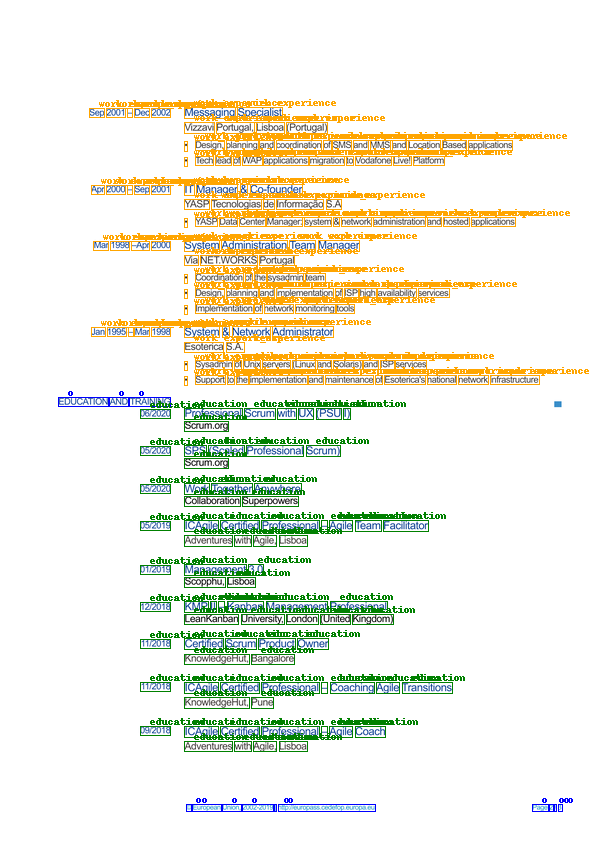

In [66]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'o'
    return label

label2color = {'o': 'blue',
               'summary': 'black', 
               'education': 'green',
               'work_experience': 'orange',
               'personal_details': 'red',
               'technical_skills': 'purple',
               'languages': 'brown',
               'other': 'violet'
               }


for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

Compare this to the ground truth:

In [ ]:
image = example["image"]
image = Image.open(example['image'])

draw = ImageDraw.Draw(image)

for word, box, label in zip(example['tokens'], example['bboxes'], example['ner_tags']):
  actual_label = iob_to_label(id2label[label]).lower()
  box = unnormalize_box(box, width, height)
  draw.rectangle(box, outline=label2color[actual_label], width=2)
  draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

image

## Note: inference when you don't have labels

The code above used the `labels` to determine which tokens were at the start of a particular word or not. Of course, at inference time, you don't have access to any labels. In that case, you can leverage the `offset_mapping` returned by the tokenizer. I do have a notebook for that (for LayoutLMv2, but it's equivalent for LayoutLMv3) [here](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/LayoutLMv2/FUNSD/True_inference_with_LayoutLMv2ForTokenClassification_%2B_Gradio_demo.ipynb).